## 2026 EY AI & Data Challenge - Landsat Demonstration Notebook

This notebook demonstrates the use of Landsat data with cloud filtering. The baseline data is [Landsat Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data from the MS Planetary Computer catalog. 

### Load Python Dependencies

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
from odc.stac import stac_load

### Load the satellite data

First, we define our area of interest using latitude and longitude coordinates of the centroid. Then we define the size of the surrounding bounding box (in degrees). GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates. Finally, we define the time window consistent with a typical rice growing season.

In [2]:
# Sample region in South Africa
# Contains Water Quality Sample Site #184 and #186 on Wilge River

lat_long = (-27.2923, 28.5365) # Lat-Lon centroid location
box_size_deg = 0.15 # Surrounding box in degrees

In [3]:
# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bounds = (min_lon, min_lat, max_lon, max_lat)

In [4]:
# Define the time window
time_window="2015-01-01/2015-05-01"

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and may contain clouds. We have included both Landsat-7 and Landsat-8 data and filtered for low-cloud scenes.

In [5]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"], 
    bbox=bounds, 
    datetime=time_window,
    query={"platform": {"in": ["landsat-7", "landsat-8"]}, "eo:cloud_cover": {"lt": 10}},
)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 6


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The ODC [odc](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands, including the "qa_pixel" cloud filtering band, reproject into Lat-Lon coordinates (EPSG:4326) at 30-meters resolution (typical of Landsat pixel resolution), and clip the region to the spatial bounding box. 

In [6]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [7]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "swir16", "swir22", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

In [8]:
# Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
xx['red'] = (xx['red']*0.0000275)-0.2
xx['green'] = (xx['green']*0.0000275)-0.2
xx['blue'] = (xx['blue']*0.0000275)-0.2
xx['nir08'] = (xx['nir08']*0.0000275)-0.2
xx['swir16'] = (xx['swir16']*0.0000275)-0.2
xx['swir22'] = (xx['swir22']*0.0000275)-0.2

In [9]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset> Size: 93MB
Dimensions:      (latitude: 557, longitude: 557, time: 6)
Coordinates:
  * latitude     (latitude) float64 4kB -27.22 -27.22 -27.22 ... -27.37 -27.37
  * longitude    (longitude) float64 4kB 28.46 28.46 28.46 ... 28.61 28.61 28.61
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2015-01-03T08:02:45.736685 ... 201...
Data variables:
    red          (time, latitude, longitude) float64 15MB dask.array<chunksize=(1, 557, 557), meta=np.ndarray>
    green        (time, latitude, longitude) float64 15MB dask.array<chunksize=(1, 557, 557), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 15MB dask.array<chunksize=(1, 557, 557), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 15MB dask.array<chunksize=(1, 557, 557), meta=np.ndarray>
    swir16       (time, latitude, longitude) float64 15MB dask.array<chunksize=(1, 557, 557), meta=np.ndarray>
    swir22       (time, latitude, longitude) float64 15MB dask.array<chunksize=(1, 557, 557), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 557, 557), meta=np.ndarray>

### View RGB (real color) images from the time series

Data is available from Landsat-7 from April 1999. Data is available for Landsat-8 from April-2013 to now. A review of the available data shows that the Landdsat-7 scenes have a "banding" issue with the sensor that adds lines of "no data" to each scene. These can be removed by pixel screening but unfortunately some data is lost. So, for the selected time window and missions there are typically views of our region every 8 days. We will pick a scene with some clouds to demonstrate filtering to find the clear pixels.

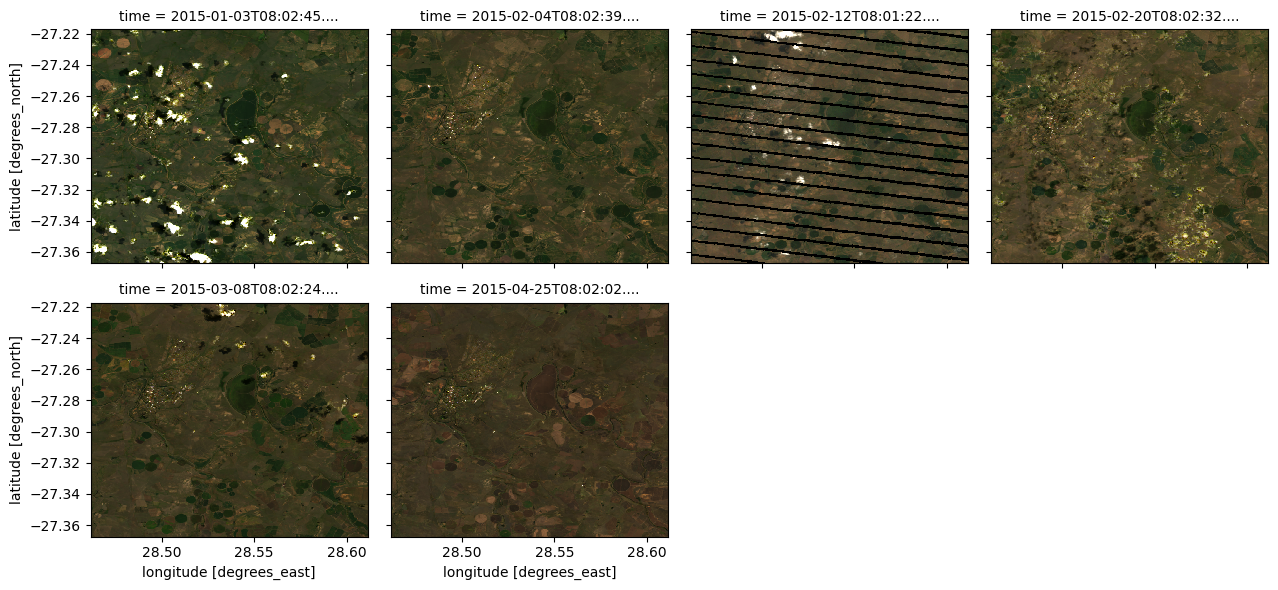

In [10]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.3)
plt.show()

In [11]:
# Select a time slice to view a simple RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

time_slice = 1

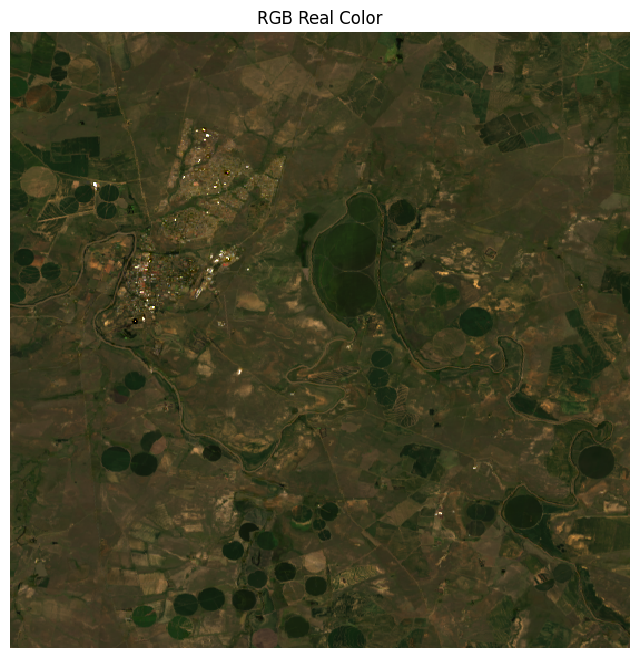

In [12]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.3)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

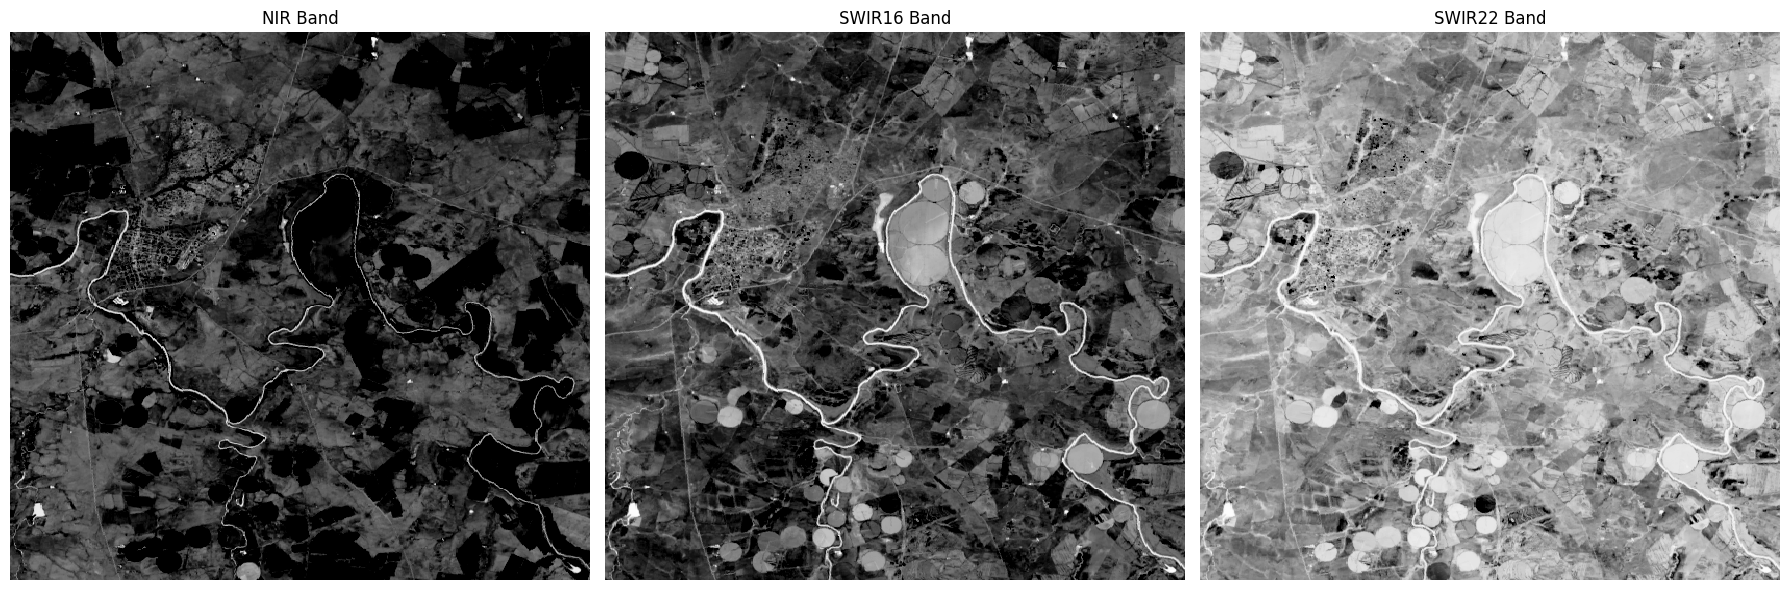

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot NIR Band
xx.isel(time=time_slice).nir08.plot.imshow(robust=True, ax=axes[0], vmin=0, vmax=0.3, cmap="Greys", add_colorbar=False)
axes[0].set_title("NIR Band")
axes[0].axis('off')

# Plot SWIR16 Band
xx.isel(time=time_slice).swir16.plot.imshow(robust=True, ax=axes[1], vmin=0, vmax=0.3, cmap="Greys", add_colorbar=False)
axes[1].set_title("SWIR16 Band")
axes[1].axis('off')

# Plot SWIR22 Band
xx.isel(time=time_slice).swir22.plot.imshow(robust=True, ax=axes[2], vmin=0, vmax=0.3, cmap="Greys", add_colorbar=False)
axes[2].set_title("SWIR22 Band")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Apply Cloud Filtering and Masking

Cloud masking for Landsat Collection-2 Level-2 data can be complicated. The <b>"qa_pixel"</b> band is used to assess each pixel and determine its cloud or water classification. The code below is credited to Mauricio Cordiero. See his webpage [HERE](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) for a more detailed explanation of the process. Also, you can visit the Landsat-8 Collection-2 Level-2 Product Guide [HERE](https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide) for more details about the cloud mask values. In the end, we are searching for clouds, cloud shadows, and water to create a mask for any given region. This will allow us to extract the "clear" pixels to assess the vegetation state. 

In [14]:
# To mask the pixels and find clouds or water, it is best to use the bit values of the 16-bit qa_pixel flag
# See the website above for a nice explanation of the process

bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2, 
            'cloud': 1<<3,
            'shadow': 1<<4, 
            'snow': 1<<5, 
            'clear': 1<<6,
            'water': 1<<7
}

In [15]:
# Create a function that will mask pixels with a given type

def get_mask(mask, flags_list):
    
    # Create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)
    
    # Loop through the flags  
    for flag in flags_list:
        
        # get the mask for each flag
        flag_mask = np.bitwise_and(mask, bit_flags[flag])
        
        # add it to the final flag
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

In [16]:
# Pick a single time slice to view a mask with clouds and water
sample_xx = xx.isel(time=time_slice)

In [17]:
# Find the pixels that are no data (fill), clouds, cloud shadows, or water
my_mask = get_mask(sample_xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])

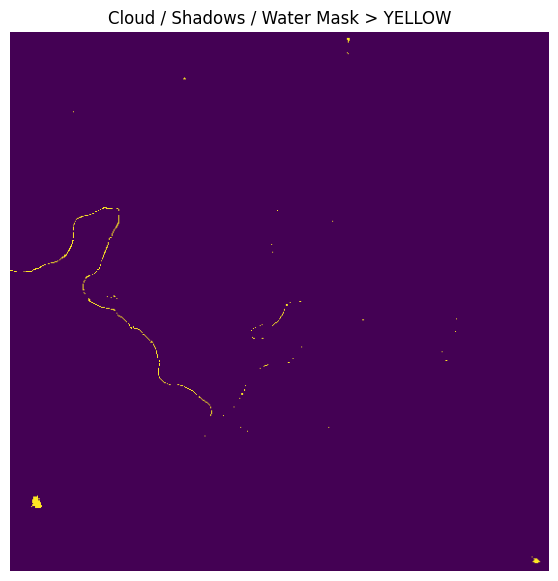

In [18]:
# Show only the mask (Yellow) with valid data in Purple
plt.figure(figsize=(7,7))
plt.imshow(my_mask)
plt.title("Cloud / Shadows / Water Mask > YELLOW")
plt.axis('off')
plt.show()

### Prepare a data mask before plotting sample products

In [19]:
# Calculate the mask for the entire xarray (all time slices)
full_mask = get_mask(xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])

In [20]:
# Create a "clean" dataset with the mask applied 
cleaned_data = xx.where(~full_mask)

### Normalized Difference Vegetation Index (NDVI)

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, water), middle values (0.25 to 0.6) reflect crops in their growing state, and high values (0.6 to 1.0) reflect crops at their peak vegetation state. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

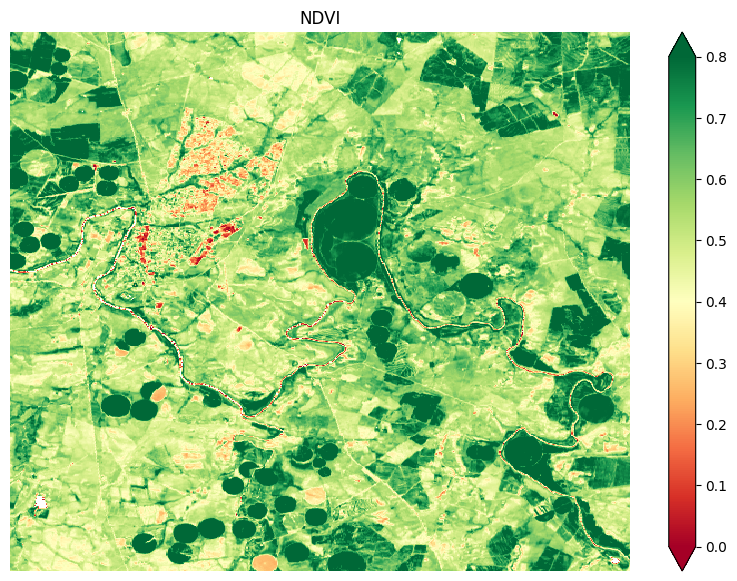

In [21]:
# Plot an NDVI image for a single date with few clouds
fig = plt.figure(figsize=(10, 7))
ndvi_image = (cleaned_data.nir08-cleaned_data.red)/(cleaned_data.nir08+cleaned_data.red)
ndvi_image.isel(time=time_slice).plot(vmin=0.0, vmax=0.8, cmap="RdYlGn")
plt.title("NDVI")
plt.axis('off')
plt.show()

### Normalized Difference Moisture Index (NDMI)

The <b>Normalized Difference Moisture Index (NDVI)</b> is used to measure the presence of soil moisture stress level of vegetation and has a range of -1.0 to 1.0. Higher values (0.4 to 1.0) indicate high vegetation water content, often seen in healthy, well-irrigated areas. Lower values (0 to 0.2) suggest low water content or potential water stress. Very low values (-1.0 to 0.0) typically correspond to bare soil or areas with little to no vegetation moisture. The equation uses two spectral bands where: <b>NDMI = (NIR-SWIR16) / (NIR+SWIR16).

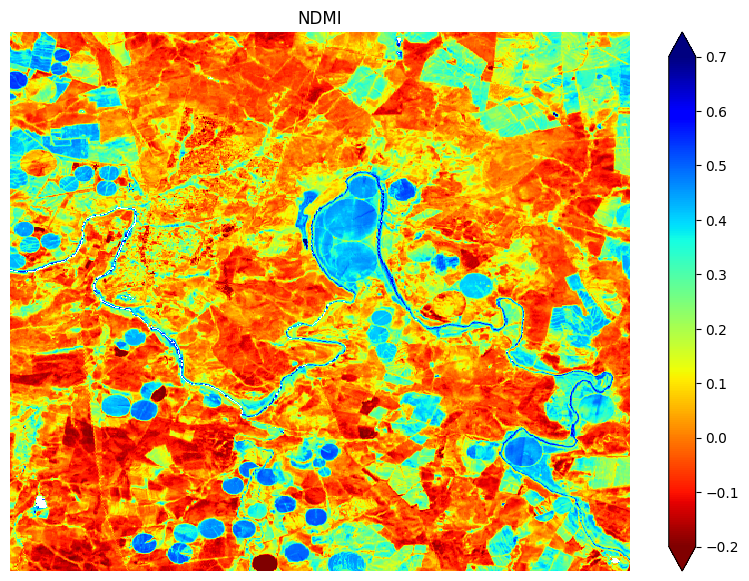

In [22]:
# Plot an NDMI image for a single date with few clouds
fig = plt.figure(figsize=(10, 7))
ndvi_image = (cleaned_data.nir08-cleaned_data.swir16)/(cleaned_data.nir08+cleaned_data.swir16)
ndvi_image.isel(time=time_slice).plot(vmin=-0.2, vmax=0.7, cmap="jet_r")
plt.title("NDMI")
plt.axis('off')
plt.show()

### SWIR-22 (Shortwave Infrared #2)
The Shortwave Infrared #2 band (SWIR22) has a wavelength range of 2.11 to 2.29 microns. This band is typically used for characterizing vegetation and land cover, with applications in estimating fractional crop residue cover, monitoring crop health, and distinguishing soil from vegetation. It is a critical tool for long-term land use analysis and change detection in agriculture, forestry, and coastal environments. 

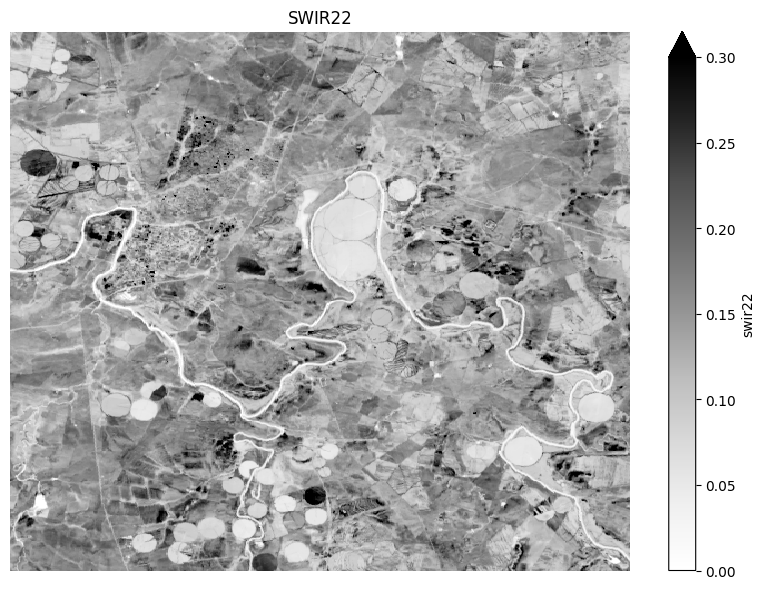

In [23]:
# Plot an SWIR-22 image for a single date with few clouds
fig = plt.figure(figsize=(10, 7))
swir22_image = cleaned_data.swir22
swir22_image.isel(time=time_slice).plot(vmin=0.0, vmax=0.3, cmap="Greys")
plt.title("SWIR22")
plt.axis('off')
plt.show()